## Setup 

In [1]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
from scipy.misc import imresize as imresize
from PIL import Image


# Custom imports
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import copy

# Imports from files in project/
import sys
sys.path.append("../../")
from run_placesCNN_unified import load_labels, load_model, returnCAM, hook_feature
import wideresnet
from timeit import default_timer as timer
import pandas as pd

## Data Parameters

In [2]:
# Data location
datadir = '../data/images/'
traindir = datadir + 'train/'
validdir = datadir + 'val/'
testdir = datadir + 'test/'
trainsampledir = datadir + 'train_sample/'
valsampledir = datadir + 'val_sample/'


# Output files
save_file_name = 'places365-transfer-v1.pth'
checkpoint_path = 'places365-transfer-v1.pth'

# Batch size
batch_size = 128

# GPU Settings
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
if train_on_gpu:
    gpu_count = torch.cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    
# Images per set
for group in ['train', 'val', 'test']:
    for label in [0, 1]:
        path = datadir + group + '/' + str(label)
        print(group, label, '-', len(os.listdir(path)))

Train on gpu: True
1 gpus detected.
train 0 - 4392
train 1 - 5970
val 0 - 1541
val 1 - 1913
test 0 - 1454
test 1 - 2000


## Image Preprocessing

In [3]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
        trn.Compose([
        trn.Resize(size=256),
        trn.RandomRotation(degrees=15),
        trn.ColorJitter(),
        trn.RandomHorizontalFlip(),
        trn.CenterCrop(size=224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    # Validation does not use augmentation
    'val':
        trn.Compose([
        trn.Resize(size=256),
        trn.CenterCrop(size=224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    # Test does not use augmentation
    'test':
        trn.Compose([
        trn.Resize(size=256),
        trn.CenterCrop(size=224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Data Iterators

In [4]:
trainsampledir  

data = {
    'train': datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val': datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test': datasets.ImageFolder(root=testdir, transform=image_transforms['test']),
    'train_sample': datasets.ImageFolder(root=trainsampledir, transform=image_transforms['train']),
    'val_sample': datasets.ImageFolder(root=valsampledir, transform=image_transforms['val']),
}


# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True),
    'train_sample': DataLoader(data['train_sample'], batch_size=batch_size, shuffle=True),
    'val_sample': DataLoader(data['val_sample'], batch_size=batch_size, shuffle=True),
}

In [5]:
trainiter = iter(dataloaders['val_sample'])
features, labels = next(trainiter)
print(features.shape, labels.shape, 'batch dimensions')
print(len(data['val_sample'].classes), 'classes')
print(data['val_sample'])

torch.Size([128, 3, 224, 224]) torch.Size([128]) batch dimensions
2 classes
Dataset ImageFolder
    Number of datapoints: 314
    Root Location: ../data/images/val_sample/
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None


## Counting the number of values within a directory

In [192]:
# This counts the number values within the valsample directory
for d in os.listdir(trainsampledir):
    print("class:", d)
    
    items = os.listdir(trainsampledir + d)
    print("item count:", len(items))
    

class: 0
item count: 398
class: 1
item count: 583


In [7]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

## Create the models

In [107]:
def create_models(in_model):
    models = []
    cnt = 6

    for i in range(cnt):
        models.append(copy.deepcopy(in_model))
        
    for m_no in range(len(models)):
        if m_no == 0:
            input_size = models[m_no].fc.in_features
            n_classes = 2
            hidden_size = 100

            models[m_no].fc = nn.Sequential(
                nn.Linear(input_size, hidden_size), nn.ReLU(),
                nn.Linear(hidden_size, n_classes)
            )
        elif m_no == 1:
            input_size = models[m_no].fc.in_features
            n_classes = 2
            hidden_size = [256, 128]

            models[m_no].fc = nn.Sequential(
                Flatten(), nn.Linear(input_size, hidden_size[0]), nn.ReLU(),
                nn.Linear(hidden_size[0], hidden_size[1]), nn.ReLU(),
                nn.Linear(hidden_size[1], n_classes)
            )
            
        elif m_no == 2:
            input_size = models[m_no].fc.in_features
            n_classes = 2
            hidden_size = [256, 128]

            models[m_no].fc = nn.Sequential(
                Flatten(), nn.Linear(input_size, hidden_size[0]), nn.ReLU(), nn.Dropout(0.25),
                nn.Linear(hidden_size[0], hidden_size[1]), nn.ReLU(), nn.Dropout(0.25),
                nn.Linear(hidden_size[1], n_classes)
            )
            
        elif m_no == 3:
            input_size = models[m_no].fc.in_features
            n_classes = 2
            hidden_size = [256, 128]

            models[m_no].fc = nn.Sequential(
                Flatten(), nn.Linear(input_size, hidden_size[0]), nn.ReLU(), nn.Dropout(0.25),
                nn.Linear(hidden_size[0], hidden_size[1]), nn.ReLU(), nn.Dropout(0.25),
                nn.Linear(hidden_size[1], n_classes), nn.LogSoftmax(dim=1)
            )
            
        elif m_no == 4:
            input_size = models[m_no].fc.in_features
            n_classes = 2
            hidden_size = [128, 32]
            
            models[m_no].fc = nn.Sequential(
                Flatten(), nn.Linear(input_size, hidden_size[0]), nn.ReLU(), nn.Dropout(0.25),
                nn.Linear(hidden_size[0], hidden_size[1]), nn.ReLU(), nn.Dropout(0.10),
                nn.Linear(hidden_size[1], n_classes), nn.LogSoftmax(dim=1)
            )
        if m_no == 5:
            input_size = models[m_no].fc.in_features
            n_classes = 2
            hidden_size = 256

            models[m_no].fc = nn.Sequential(
                Flatten(),
                nn.Linear(input_size, hidden_size), 
                nn.LeakyReLU(negative_slope = 0.01),
                nn.Dropout(0.1),
                nn.Linear(hidden_size, n_classes),
                torch.nn.LogSoftmax(dim=1)
            )
            
    return models

## Load the models

In [108]:
def load_model():
    
    # Load the wideresnet model
    model = wideresnet.resnet18(num_classes=365)
    
    # Load in the pretrained weights
    model_file = 'wideresnet18_places365.pth.tar'
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    
#     # Add hooks for attributes and CAM
#     features_names = ['layer4','avgpool']
#     for name in features_names:
#         model._modules.get(name).register_forward_hook(hook_feature)

    # Freeze model weights
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final layer with a FC mapping to binary classes
#     n_inputs = model.fc.in_features
#     model.fc = torch.nn.Sequential(
#         torch.nn.Linear(n_inputs, 256), torch.nn.ReLU(), torch.nn.Dropout(0.2),
#         torch.nn.Linear(256, 2), torch.nn.LogSoftmax(dim=1))

    models = create_models(model)
    
    # Move to GPU
    if train_on_gpu:
        for m in models:
            m.to('cuda')
            
    return models

# model = load_model()
models = load_model()

for m in models:
    print(m.fc)

Sequential(
  (0): Linear(in_features=512, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
)
Sequential(
  (0): Flatten()
  (1): Linear(in_features=512, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)
Sequential(
  (0): Flatten()
  (1): Linear(in_features=512, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.25)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.25)
  (7): Linear(in_features=128, out_features=2, bias=True)
)
Sequential(
  (0): Flatten()
  (1): Linear(in_features=512, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.25)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.25)
  (7): Linear(in_features=128, out_features=2, bias=True)
  (8): LogSoftmax()
)
Sequential(
  (0): Flatten()
  

In [109]:
# for m in range(len(models)):
#     total_params = sum(p.numel() for p in models[m].parameters())
#     print(f'{total_params:,} total parameters.')
#     total_trainable_params = sum(p.numel() for p in models[m].parameters() if p.requires_grad)
#     print(f'{total_trainable_params:,} training parameters.')
    

total_params = sum(p.numel() for p in models[0].parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in models[0].parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

11,228,014 total parameters.
51,502 training parameters.


## Set Criterion and Optimizer

A new variable has been added here to store an optimizer for each model
- total_opt: stores the optimizer for each model

In [110]:
criterion = torch.nn.CrossEntropyLoss() # TODO: is 'cuda' right here?

total_opt = []
for m in range(len(models)):
    optimizer = torch.optim.Adam(models[m].parameters())
    total_opt.append(optimizer)

# models[2].parameters()

## model classes

In [194]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:2]

[(0, '0'), (1, '1')]

In [201]:
# data['train']

Dataset ImageFolder
    Number of datapoints: 10362
    Root Location: ../data/images/train/
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             RandomRotation(degrees=(-15, 15), resample=False, expand=False)
                             ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
                             RandomHorizontalFlip(p=0.5)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

## Train

In [111]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    
    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []
    all_outputs = []
    all_targets = []
    
    classes = []
    losses = []
    
    acc_results = np.zeros((len(valid_loader.dataset), 1))
    i = 0
    
    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                #print('cuda')
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)
                    
                    ####### Evan's code here ######
#                     for pred, true in zip(output, target):
#                         acc_results[i,:] = accuracy(pred.unsqueeze(0), true.unsqueeze(0), 1)
#                         classes.append(model.idx_to_class[true.item()])
#                         loss = criterion(pred.view(1, n_classes), true.view(1))
#                         losses.append(loss.item())
#                         i += 1
                    all_outputs.append(output)
                    all_targets.append(target)
                    ##################################

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))

                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history, all_outputs, all_targets

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history, all_outputs, all_targets

## Run through all of the models

A few new variables are introduced here compared to the original script. 

- total_history: a list that stores all of the history for each model, this includes train/val acc/loss for each model

- all_models: stores every model after it is done training.

In [112]:
dataloaders['train_sample']

In [113]:
model, history, all_outputs, all_targets = train(
    models[5],
    criterion,
    total_opt[5],
    dataloaders['train_sample'],
    dataloaders['val_sample'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=15,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 10.95 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.6837 	Validation Loss: 0.6812
		Training Accuracy: 58.31%	 Validation Accuracy: 54.46%
Epoch: 1	100.00% complete. 10.68 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.6522 	Validation Loss: 0.6781
		Training Accuracy: 61.57%	 Validation Accuracy: 55.10%
Epoch: 2	100.00% complete. 10.59 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.6268 	Validation Loss: 0.6387
		Training Accuracy: 63.81%	 Validation Accuracy: 65.92%
Epoch: 3	100.00% complete. 11.33 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.6169 	Validation Loss: 0.6388
		Training Accuracy: 65.85%	 Validation Accuracy: 63.69%
Epoch: 4	100.00% complete. 11.05 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.6130 	Validation Loss: 0.7324
		Training Accuracy: 66.97%	 Validation Accuracy: 54.78%
Epoch: 5	100.00% complete. 10.59 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.6108 	Validation

In [114]:
print(len(all_targets[0]))

128


In [181]:

def get_stuff(all_targets, all_outputs):
    print(len(all_targets[0]), len(all_outputs[0]))
        
#     print(all_outputs[40])
    i = 0
    class1Total = []
    class0Total = []
    pred = []
    
    while i < len(all_outputs):
        maxima = np.argmax(all_outputs[i], axis=1)
        pred.append(maxima)
        class1Total.append(torch.sum(maxima).item())
        class0Total.append(len(maxima) - torch.sum(maxima).item())
        i += 3
    
#     print(class1Total, class0Total)

    j = 0
    print(len(pred))
    print(len(all_targets))
       

    while j < len(all_targets):
        print(j)
        y = np.asarray(all_targets[j])
        yhat = np.asarray(pred[j])
        
        class1cnt = 0
        class0cnt = 0
        
        for k in range(len(y)):
            if y[k] == yhat[k]:
                if y[k] == 0:
                    class0cnt += 1
                elif y[k] == 1:
                    class1cnt += 1
                
        print("class 0 count", class0cnt)
        print("class 1 count", class1cnt)
                
        
        j += 3
    
    
    
    return

In [182]:
# get_stuff(all_targets, all_outputs)

128 128
15
45
0
class 0 count 4
class 1 count 68
3
class 0 count 17
class 1 count 59
6
class 0 count 16
class 1 count 48
9
class 0 count 19
class 1 count 52
12
class 0 count 1
class 1 count 60
15


IndexError: list index out of range

In [65]:
total_history = []
all_models = []

for m in range(len(models)):
    print("Testing Model #{}".format(m))
    print(models[m].fc)
    
    model, history = train(
        models[m],
        criterion,
        total_opt[m],
        dataloaders['train_sample'],
        dataloaders['val_sample'],
        save_file_name=save_file_name,
        max_epochs_stop=5,
        n_epochs=20,
        print_every=1)
    
    total_history.append(history)
    all_models.append(model)

    
    

Testing Model #0
Sequential(
  (0): Linear(in_features=512, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
)
Starting Training from Scratch.

Epoch: 0	100.00% complete. 11.08 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.6892 	Validation Loss: 0.7190
		Training Accuracy: 55.56%	 Validation Accuracy: 52.55%
Epoch: 1	100.00% complete. 12.09 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.6867 	Validation Loss: 0.6720
		Training Accuracy: 60.04%	 Validation Accuracy: 62.10%
Epoch: 2	100.00% complete. 10.61 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.6572 	Validation Loss: 0.6934
		Training Accuracy: 63.20%	 Validation Accuracy: 52.23%
Epoch: 3	100.00% complete. 10.89 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.6439 	Validation Loss: 0.6577
		Training Accuracy: 60.96%	 Validation Accuracy: 63.69%
Epoch: 4	100.00% complete. 10.88 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.6329 	Validation Loss: 0.6

Epoch: 13	100.00% complete. 10.61 seconds elapsed in epoch.
Epoch: 13 	Training Loss: 0.5822 	Validation Loss: 0.7269
		Training Accuracy: 70.34%	 Validation Accuracy: 60.19%
Epoch: 14	100.00% complete. 10.64 seconds elapsed in epoch.
Epoch: 14 	Training Loss: 0.5806 	Validation Loss: 0.6564
		Training Accuracy: 69.93%	 Validation Accuracy: 64.01%
Epoch: 15	100.00% complete. 10.70 seconds elapsed in epoch.
Epoch: 15 	Training Loss: 0.5714 	Validation Loss: 0.6369
		Training Accuracy: 70.23%	 Validation Accuracy: 64.01%

Early Stopping! Total epochs: 15. Best epoch: 10 with loss: 0.63 and acc: 64.01%
228.87 total seconds elapsed. 14.30 seconds per epoch.


## Evaluation

In [195]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [198]:
def evaluate(model, test_loader, criterion, topk=(1,2)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, 2), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [200]:
results = evaluate(model, dataloaders['val_sample'], criterion)
results.head()

,class,top1,top2,loss
0,0,59.060403,100.0,0.664335
1,1,70.909091,100.0,0.563158


## Vizualize Results 

Quick test to show how the values are extracted out of total_history

In [66]:
print(total_history[0]['train_loss'])

0     0.689195
1     0.686691
2     0.657208
3     0.643903
4     0.632924
5     0.620844
6     0.611568
7     0.600216
8     0.595527
9     0.587685
10    0.592153
11    0.585555
12    0.582918
13    0.566700
14    0.585562
15    0.563280
16    0.556896
17    0.554089
18    0.550863
19    0.551222
Name: train_loss, dtype: float64


## Plot the Training/Validation Loss

A couple things here are added to the original script:
- a for loop that iterates m over the 'total_history'
- replace the value in plt.plot with 'total_history'

All of these changes just make it easier to plot all of them on the same screen

Text(0.5,1,'Training and Validation Losses')

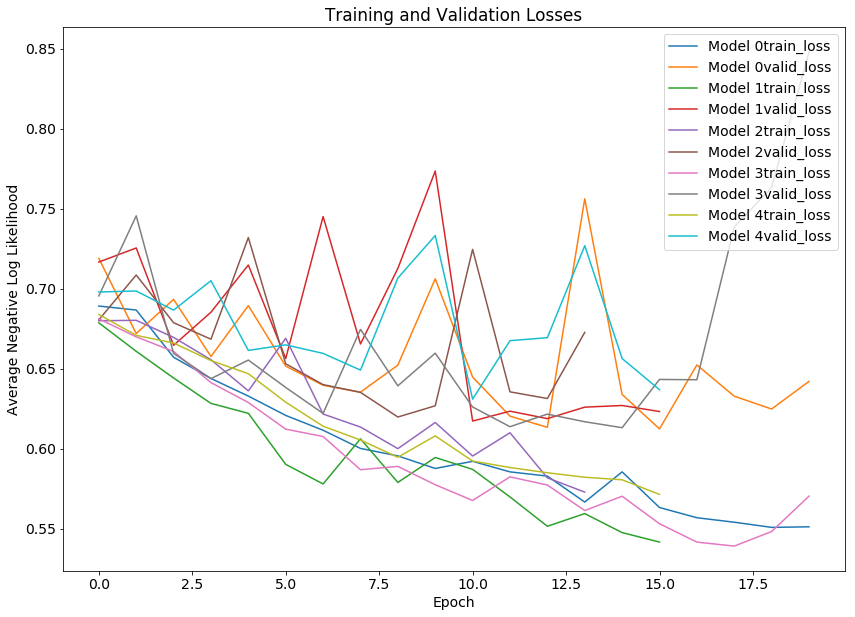

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

plt.figure(figsize=(14, 10))
for m in range(len(total_history)):
    for c in ['train_loss', 'valid_loss']:
        plt.plot(
            total_history[m][c], label= "Model {}".format(m) + c )
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

## Plot the training/validation accuracy

A couple things here are added to the original script:
- a for loop that iterates m over the 'total_history'
- replace the value in plt.plot with 'total_history'

All of these changes just make it easier to plot all of them on the same screen

Text(0.5,1,'Training and Validation Accuracy')

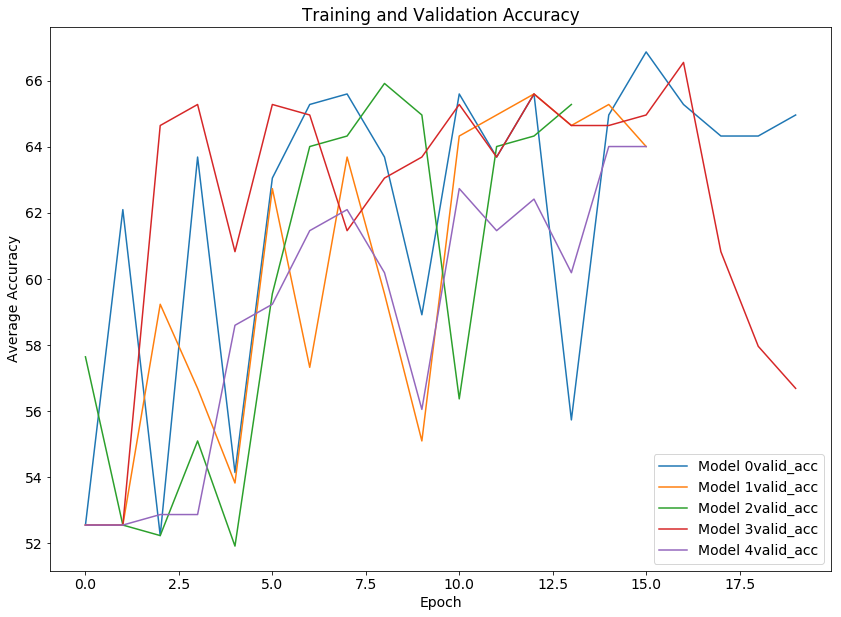

In [71]:
plt.figure(figsize=(14, 10))
for m in range(len(total_history)):
    for c in ['valid_acc']:
        plt.plot(
            100 * total_history[m][c], label= "Model {}".format(m) + c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
# plt.axis([None, None, 25, 75])


In [58]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [ ]:
save_checkpoint(model, path=checkpoint_path)

In [ ]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer